# Time Series Datasets

This notebook shows how to create a time series dataset from some csv file in order to then share it on the [🤗 hub](https://huggingface.co/docs/datasets/index). We will use the GluonTS library to read the csv into the appropriate format. We start by installing the libraries

In [1]:
! pip install -q datasets gluonts orjson

  You can safely remove it manually.
  You can safely remove it manually.


GluonTS comes with a pandas DataFrame based dataset so our strategy will be to read the csv file, and process it as a `PandasDataset`. We will then iterate over it and convert it to a 🤗 dataset with the appropriate schema for time series. So lets get started!

## `PandasDataset`

Suppose we are given multiple (10) time series stacked on top of each other in a dataframe with an `item_id` column that distinguishes different series:

In [2]:
import pandas as pd

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df.head()

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


In [10]:
df

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A
...,...,...
2021-01-10 19:00:00,1.2349,J
2021-01-10 20:00:00,1.1525,J
2021-01-10 21:00:00,1.1485,J
2021-01-10 22:00:00,1.3248,J


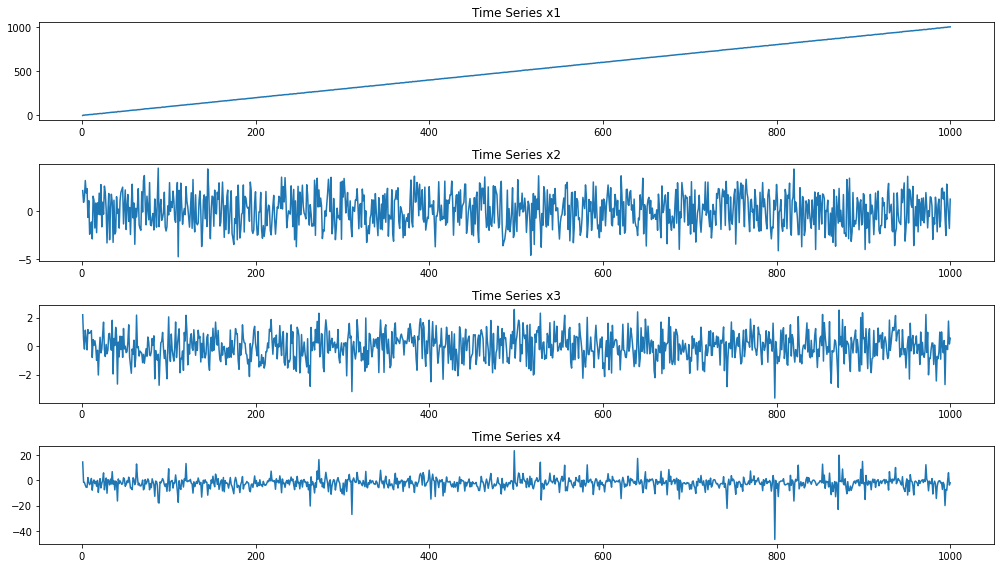

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
N = 1000  # Length of the time series
alpha = 1.0  # Value of alpha
beta = 0.5  # Value of beta
noise_std = 1.0  # Standard deviation of noise

# Time vector
t = np.linspace(1, N, N)

# Piecewise function β(t)
beta_t = np.where(t <= N / 2, 0, beta)

# Function z(t) = αt + β(t)
z_t = alpha * t + beta_t

# Noise terms
e1 = np.random.normal(0, noise_std, N)
e2 = np.random.normal(0, noise_std, N)
e3 = np.random.normal(0, noise_std, N)
e4 = np.random.normal(0, noise_std, N)

# Equations for x1, x2, x3, x4
x1 = z_t + e1
x2 = -2 * np.sin(2 * x1) + e2
x3 = np.exp(-x1) * x2 + e3
x4 = x3**3 - x2**2 * np.cos(x3) + e4

# Plot the time series
plt.figure(figsize=(14, 8))
plt.subplot(4, 1, 1)
plt.plot(t, x1)
plt.title('Time Series x1')

plt.subplot(4, 1, 2)
plt.plot(t, x2)
plt.title('Time Series x2')

plt.subplot(4, 1, 3)
plt.plot(t, x3)
plt.title('Time Series x3')

plt.subplot(4, 1, 4)
plt.plot(t, x4)
plt.title('Time Series x4')

plt.tight_layout()
plt.show()
data = pd.DataFrame({
    'X1': x1,
    'X2': x2,
    'X3': x3,
    'Y1': x4
})

In [40]:
data["id"] = "A"

In [41]:
data

,X1,X2,X3,Y1,id
1970-01-01 00:00:00.000000000,-0.561115,2.083318,2.198179,14.294615,A
1970-01-01 00:00:00.000000001,3.011059,0.874046,0.479559,-1.669367,A
1970-01-01 00:00:00.000000002,2.952192,1.389131,-0.207670,-1.770761,A
1970-01-01 00:00:00.000000003,5.256488,3.122017,1.117919,-3.994596,A
1970-01-01 00:00:00.000000004,5.601191,1.835542,0.494371,-5.565390,A
...,...,...,...,...,...
1970-01-01 00:00:00.000000995,995.573838,2.753858,-0.189333,-7.966004,A
1970-01-01 00:00:00.000000996,998.754725,1.088703,-0.238752,-0.392797,A
1970-01-01 00:00:00.000000997,999.464151,-0.302390,1.754629,5.853647,A
1970-01-01 00:00:00.000000998,1000.312360,-1.816436,0.146233,-3.865334,A


In [33]:
df

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A
...,...,...
2021-01-10 19:00:00,1.2349,J
2021-01-10 20:00:00,1.1525,J
2021-01-10 21:00:00,1.1485,J
2021-01-10 22:00:00,1.3248,J


After converting it into a `pd.Dataframe` we can then convert it into GluonTS's `PandasDataset`:

In [23]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

In [42]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(data, target="Y1", item_id="id")


## 🤗 Datasets

From here we have to map the pandas dataset's `start` field into a time stamp instead of a `pd.Period`. We do this by defining the following class:

In [34]:
class ProcessStartField():
    ts_id = 0
    
    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        self.ts_id += 1
        
        return data

In [43]:
from gluonts.itertools import Map

process_start = ProcessStartField()

list_ds = list(Map(process_start, ds))

Next we need to define our schema features and create our dataset from this list via the `from_list` function:

In [44]:


from datasets import Dataset, Features, Value, Sequence

features  = Features(
    {    
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        # "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
    }
)

In [45]:
dataset = Dataset.from_list(list_ds, features=features)

In [55]:
# Assume list_ds is your dataset in list format
dataset_size = len(list_ds)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)

# Splitting the dataset
train_dataset = list_ds[:train_size]
val_dataset = list_ds[train_size:train_size + val_size]
test_dataset = list_ds[train_size + val_size:]

# Converting back to GluonTS datasets if necessary
from gluonts.dataset.common import ListDataset

# Assuming all your datasets are similar in structure and the first element can represent the structure
def convert_to_gluonts_dataset(dataset_list):
    return ListDataset(dataset_list, freq='H', one_dim_target=False)

train_ds_gluonts = convert_to_gluonts_dataset(train_dataset)
val_ds_gluonts = convert_to_gluonts_dataset(val_dataset)
test_ds_gluonts = convert_to_gluonts_dataset(test_dataset)


GluonTSDataError: Array 'target' has bad shape - expected 2 dimensions, got 1.

In [47]:
train_example = dataset[0]
train_example

{'start': datetime.datetime(1970, 1, 1, 0, 0),
 'target': [14.294614791870117,
  -1.6693668365478516,
  -1.770761251449585,
  -3.994595527648926,
  -5.565389633178711,
  -5.569389343261719,
  2.0614871978759766,
  -1.6079516410827637,
  -3.5103392601013184,
  -2.191585063934326,
  1.357019305229187,
  -7.833664417266846,
  -1.4363631010055542,
  0.18019677698612213,
  -2.685727119445801,
  -0.9850602149963379,
  -4.759191513061523,
  -0.1693723201751709,
  -9.608491897583008,
  -2.895817518234253,
  1.1958543062210083,
  -6.0973801612854,
  -2.5120129585266113,
  -0.05218442901968956,
  5.7530837059021,
  -7.493802070617676,
  -2.243345022201538,
  1.7200202941894531,
  -10.267449378967285,
  0.45343780517578125,
  -0.5331800580024719,
  -3.709185838699341,
  0.8309013843536377,
  -2.981887102127075,
  6.712075710296631,
  -3.1886515617370605,
  -0.4797089099884033,
  -7.615660667419434,
  -0.6936880350112915,
  -1.5975102186203003,
  -16.327152252197266,
  0.9818835258483887,
  -2.666

We can thus use this strategy to [share](https://huggingface.co/docs/datasets/share) the dataset to the hub.

In [58]:
import pandas as pd
from gluonts.dataset.common import ListDataset
from datetime import datetime

# Sample data creation
# Assuming x1, x2, x3, x4 are lists of your data
data = pd.DataFrame({
    'Y1': x4
})

# Assuming your data doesn't have a timestamp and you choose a start date
start_date = datetime(2020, 1, 1)

# Assuming daily frequency if your data's frequency is different, adjust accordingly
frequency = "1D"

# Convert DataFrame to GluonTS ListDataset
gluon_data = ListDataset(
    [{"start": start_date, "target": data['Y1'].values}],
    freq=frequency
)

# Splitting the data (e.g., 70% train, 15% validation, 15% test)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train_dataset = ListDataset(
    [{"start": start_date, "target": data['Y1'][:train_size].values}],
    freq=frequency
)

val_dataset = ListDataset(
    [{"start": start_date + pd.Timedelta(days=train_size), "target": data['Y1'][train_size:train_size+val_size].values}],
    freq=frequency
)

test_dataset = ListDataset(
    [{"start": start_date + pd.Timedelta(days=train_size+val_size), "target": data['Y1'][train_size+val_size:].values}],
    freq=frequency
)


In [59]:
train_dataset

[{'start': Period('2020-01-01', 'D'),
  'target': array([ 1.42946148e+01, -1.66936684e+00, -1.77076125e+00, -3.99459553e+00,
         -5.56538963e+00, -5.56938934e+00,  2.06148720e+00, -1.60795164e+00,
         -3.51033926e+00, -2.19158506e+00,  1.35701931e+00, -7.83366442e+00,
         -1.43636310e+00,  1.80196777e-01, -2.68572712e+00, -9.85060215e-01,
         -4.75919151e+00, -1.69372320e-01, -9.60849190e+00, -2.89581752e+00,
          1.19585431e+00, -6.09738016e+00, -2.51201296e+00, -5.21844290e-02,
          5.75308371e+00, -7.49380207e+00, -2.24334502e+00,  1.72002029e+00,
         -1.02674494e+01,  4.53437805e-01, -5.33180058e-01, -3.70918584e+00,
          8.30901384e-01, -2.98188710e+00,  6.71207571e+00, -3.18865156e+00,
         -4.79708910e-01, -7.61566067e+00, -6.93688035e-01, -1.59751022e+00,
         -1.63271523e+01,  9.81883526e-01, -2.66648889e+00, -4.96389717e-01,
         -1.90430272e+00, -3.28206539e+00, -2.69638991e+00,  1.92436576e+00,
          8.45219970e-01, -4